# Soil–Crop Recommendation (Supervised Learning)

**Author:** Chinwendu Nancy Anabaraonye

**Role:** Data Scientist • ML Scientist • Computational Scientist

This notebook builds an end-to-end supervised learning pipeline to recommend suitable crops based on soil chemistry characteristics. It includes minimal EDA, preprocessing, tuning, evaluation, and artifact generation.



## 1) Imports, Config, and Data Load
The dataset is soil_measures.csv was gotten from kaggle and should include soil features (`N`, `P`, `K`, `ph`) and a target column `crop` (multiclass).

In [1]:
import os, json, time, sqlite3
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from scipy.stats import randint
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# <<< UPDATE THIS PATH >>>
CSV_PATH = 'soil_measures.csv'  # e.g., './data/soil_measures.csv'
OUT_DIR = './ml_outputs'  # artifacts will be saved here

df = pd.read_csv(CSV_PATH)
df.head()

,N,P,K,ph,crop
0,90,42,43,6.502985,rice
1,85,58,41,7.038096,rice
2,60,55,44,7.840207,rice
3,74,35,40,6.980401,rice
4,78,42,42,7.628473,rice


## 2) Minimal EDA
Business‑style EDA: quick checks on structure, summary statistics, missingness, and target distribution.

In [2]:
display(df.info())
display(df.describe())
print("\nMissing values by column:\n", df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N       2200 non-null   int64  
 1   P       2200 non-null   int64  
 2   K       2200 non-null   int64  
 3   ph      2200 non-null   float64
 4   crop    2200 non-null   object 
dtypes: float64(1), int64(3), object(1)
memory usage: 86.1+ KB


None

,N,P,K,ph
count,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,6.469480
std,36.917334,32.985883,50.647931,0.773938
min,0.000000,5.000000,5.000000,3.504752
25%,21.000000,28.000000,20.000000,5.971693
50%,37.000000,51.000000,32.000000,6.425045
75%,84.250000,68.000000,49.000000,6.923643
max,140.000000,145.000000,205.000000,9.935091



Missing values by column:
 N       0
P       0
K       0
ph      0
crop    0
dtype: int64


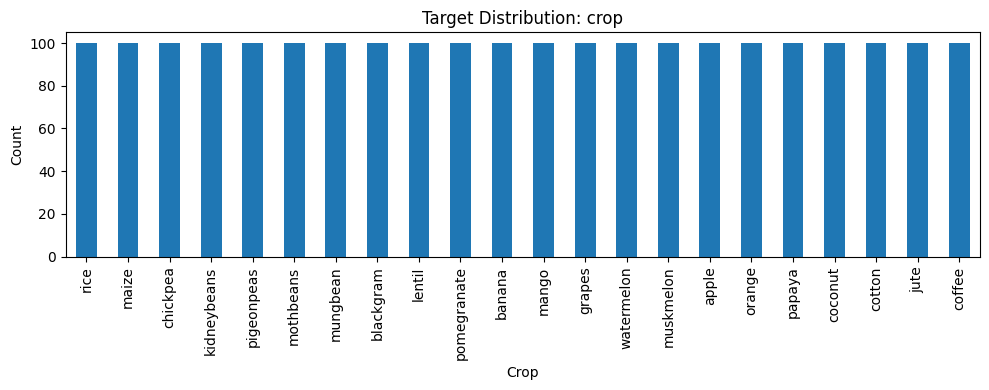

In [3]:
# Target distribution
if 'crop' in df.columns:
    ax = df['crop'].value_counts().plot(kind='bar', figsize=(10,4))
    ax.set_title('Target Distribution: crop')
    ax.set_xlabel('Crop')
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print("Column 'crop' not found. Ensure your dataset has a 'crop' target column.")

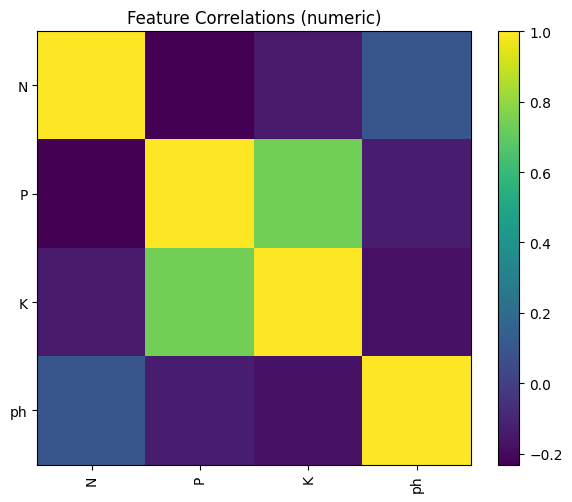

In [4]:
# Correlation heatmap for numeric features (matplotlib-only)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) > 1:
    corr = df[num_cols].corr()
    fig, ax = plt.subplots(figsize=(6,5))
    cax = ax.imshow(corr, interpolation='nearest')
    ax.set_title('Feature Correlations (numeric)')
    fig.colorbar(cax)
    ax.set_xticks(range(len(num_cols)))
    ax.set_xticklabels(num_cols, rotation=90)
    ax.set_yticks(range(len(num_cols)))
    ax.set_yticklabels(num_cols)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to compute correlations.")

## 3) Preprocessing & Baseline
Implementing a robust preprocessing pipeline and a simple baseline to establish a performance floor.

In [5]:
# Preprocessing
feature_cols = [c for c in df.columns if c != 'crop']
num_cols = [c for c in feature_cols if np.issubdtype(df[c].dtype, np.number)]
cat_cols = [c for c in feature_cols if c not in num_cols]

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_cols),
    ('cat', categorical_pipeline, cat_cols)
])

# Train/test split
X = df[feature_cols]
y = df['crop']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Baseline model (most frequent)
baseline = Pipeline([
    ('prep', preprocessor),
    ('clf', DummyClassifier(strategy='most_frequent'))
])
baseline.fit(X_train, y_train)
base_acc = accuracy_score(y_test, baseline.predict(X_test))
print(f"Baseline accuracy: {base_acc:.4f}")

Baseline accuracy: 0.0455


## 4) One‑Cell End‑to‑End: Tune → Train → Evaluate → Save Artifacts
This is the centerpiece of the notebook. It tunes multiple models via CV using macro‑F1, refits the best on the full training set, evaluates on holdout test, saves plots and a serialized model, and writes a machine‑readable summary JSON.

In [6]:
def run_full_pipeline(
    df: pd.DataFrame,
    target: str = 'crop',
    out_dir: str = './ml_outputs',
    test_size: float = 0.2,
    cv_splits: int = 5,
    scoring: str = 'f1_macro',
    n_jobs: int = -1,
):
    os.makedirs(out_dir, exist_ok=True)
    os.makedirs(os.path.join(out_dir, 'plots'), exist_ok=True)

    X = df.drop(columns=[target])
    y = df[target].astype('category')

    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=RANDOM_STATE
    )

    numeric_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    categorical_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('num', numeric_pipe, num_cols),
        ('cat', categorical_pipe, cat_cols)
    ])

    candidates = {
        'logreg': {
            'estimator': Pipeline([
                ('prep', preprocessor),
                ('clf', LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
            ]),
            'search': GridSearchCV,
            'param_grid': {
                'clf__C': [0.1, 1, 3, 10],
                'clf__penalty': ['l2'],
                'clf__solver': ['lbfgs']
            },
            'params': {'cv': StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE),
                       'scoring': scoring, 'n_jobs': n_jobs, 'refit': True}
        },
        'svm_rbf': {
            'estimator': Pipeline([
                ('prep', preprocessor),
                ('clf', SVC(kernel='rbf', probability=True, random_state=RANDOM_STATE))
            ]),
            'search': GridSearchCV,
            'param_grid': {
                'clf__C': [0.5, 1, 3, 10],
                'clf__gamma': ['scale', 0.1, 0.01, 0.001]
            },
            'params': {'cv': StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE),
                       'scoring': scoring, 'n_jobs': n_jobs, 'refit': True}
        },
        'rf': {
            'estimator': Pipeline([
                ('prep', preprocessor),
                ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
            ]),
            'search': RandomizedSearchCV,
            'param_distributions': {
                'clf__n_estimators': randint(150, 450),
                'clf__max_depth': randint(4, 30),
                'clf__min_samples_split': randint(2, 10),
                'clf__min_samples_leaf': randint(1, 6),
                'clf__max_features': ['sqrt', 'log2', None]
            },
            'params': {'n_iter': 30,
                       'cv': StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE),
                       'scoring': scoring, 'n_jobs': n_jobs, 'refit': True, 'random_state': RANDOM_STATE}
        },
        'hgb': {
            'estimator': Pipeline([
                ('prep', preprocessor),
                ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))
            ]),
            'search': GridSearchCV,
            'param_grid': {
                'clf__learning_rate': [0.05, 0.1, 0.2],
                'clf__max_depth': [None, 3, 6, 12],
                'clf__min_samples_leaf': [10, 20, 30],
                'clf__l2_regularization': [0.0, 0.1, 0.5]
            },
            'params': {'cv': StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE),
                       'scoring': scoring, 'n_jobs': n_jobs, 'refit': True}
        }
    }

    rows = []
    best_global = {'name': None, 'search': None, 'cv_score': -np.inf}

    for name, spec in candidates.items():
        est = spec['estimator']
        Search = spec['search']
        params = spec['params'].copy()

        if Search is GridSearchCV:
            search_obj = Search(est, spec['param_grid'], **params)
        else:
            search_obj = Search(est, spec['param_distributions'], **params)

        t0 = time.time()
        search_obj.fit(X_train, y_train)
        t1 = time.time()

        rows.append({
            'model': name,
            'best_params': search_obj.best_params_,
            'cv_best_score_macroF1': search_obj.best_score_,
            'fit_seconds': round(t1 - t0, 2)
        })

        if search_obj.best_score_ > best_global['cv_score']:
            best_global.update({'name': name, 'search': search_obj, 'cv_score': search_obj.best_score_})

    results_df = pd.DataFrame(rows).sort_values('cv_best_score_macroF1', ascending=False).reset_index(drop=True)
    best_name = best_global['name']
    best_search = best_global['search']
    best_model = best_search.best_estimator_

    y_pred = best_model.predict(X_test)
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'macro_f1': f1_score(y_test, y_pred, average='macro')
    }

    report_txt = classification_report(y_test, y_pred, digits=3)
    with open(os.path.join(out_dir, 'classification_report.txt'), 'w') as f:
        f.write(f"Best model: {best_name}\n\n")
        f.write(f"Best CV macro-F1: {best_global['cv_score']:.4f}\n\n")
        f.write(report_txt)

    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, ax=ax, xticks_rotation=90)
    ax.set_title(f'Confusion Matrix — {best_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'plots', 'confusion_matrix.png'), dpi=150)
    plt.close(fig)

    train_sizes, train_scores, val_scores = learning_curve(
        best_model, X_train, y_train,
        cv=StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE),
        scoring=scoring, n_jobs=n_jobs, train_sizes=np.linspace(0.1, 1.0, 6), shuffle=True, random_state=RANDOM_STATE
    )
    fig2, ax2 = plt.subplots(figsize=(7,5))
    ax2.plot(train_sizes, train_scores.mean(axis=1), marker='o', label='Training (' + scoring + ')')
    ax2.plot(train_sizes, val_scores.mean(axis=1), marker='o', label='CV (' + scoring + ')')
    ax2.set_xlabel('Training examples'); ax2.set_ylabel(scoring); ax2.legend()
    ax2.set_title(f'Learning Curve — {best_name}')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'plots', 'learning_curve.png'), dpi=150)
    plt.close(fig2)

    joblib.dump(best_model, os.path.join(out_dir, 'best_model.joblib'))

    summary = {
        'random_state': RANDOM_STATE,
        'classes': y.cat.categories.tolist(),
        'n_samples': int(df.shape[0]),
        'n_features': int(X.shape[1]),
        'numeric_features': num_cols,
        'categorical_features': cat_cols,
        'best_model_name': best_name,
        'best_cv_macro_f1': float(best_global['cv_score']),
        'best_params': best_search.best_params_,
        'test_metrics': {k: float(v) for k, v in metrics.items()},
        'created_at': datetime.now().isoformat()
    }
    with open(os.path.join(out_dir, 'summary.json'), 'w') as f:
        json.dump(summary, f, indent=2)

    print(f"\nBest model: {best_name}")
    print(f"CV macro-F1 (best): {best_global['cv_score']:.4f}")
    print('Test metrics:', metrics)
    print("\n=== Classification report ===\n", report_txt)
    print(f"\nArtifacts saved in: {os.path.abspath(out_dir)}")

    return best_model, results_df, metrics

# Run the full pipeline
best_model, leaderboard, test_metrics = run_full_pipeline(df, target='crop', out_dir=OUT_DIR)
display(leaderboard)
test_metrics


Best model: hgb
CV macro-F1 (best): 0.8191
Test metrics: {'accuracy': 0.7886363636363637, 'balanced_accuracy': 0.7886363636363637, 'macro_f1': 0.7868490466940898}

=== Classification report ===
               precision    recall  f1-score   support

       apple      0.636     0.700     0.667        20
      banana      1.000     1.000     1.000        20
   blackgram      0.609     0.700     0.651        20
    chickpea      1.000     1.000     1.000        20
     coconut      0.762     0.800     0.780        20
      coffee      1.000     1.000     1.000        20
      cotton      1.000     1.000     1.000        20
      grapes      0.667     0.600     0.632        20
        jute      0.636     0.700     0.667        20
 kidneybeans      0.826     0.950     0.884        20
      lentil      0.500     0.550     0.524        20
       maize      0.952     1.000     0.976        20
       mango      0.889     0.800     0.842        20
   mothbeans      0.889     0.800     0.842    

,model,best_params,cv_best_score_macroF1,fit_seconds
0,hgb,"{'clf__l2_regularization': 0.1, 'clf__learning...",0.819082,82.71
1,rf,"{'clf__max_depth': 17, 'clf__max_features': 'l...",0.807761,13.49
2,svm_rbf,"{'clf__C': 10, 'clf__gamma': 'scale'}",0.773152,3.01
3,logreg,"{'clf__C': 10, 'clf__penalty': 'l2', 'clf__sol...",0.678945,3.18


{'accuracy': 0.7886363636363637,
 'balanced_accuracy': 0.7886363636363637,
 'macro_f1': 0.7868490466940898}

## 5) Results Interpretation
Load the saved `summary.json` , review balanced accuracy and macro‑F1, and inspect class‑level performance.

In [7]:
with open(Path(OUT_DIR) / 'summary.json') as f:
    summary = json.load(f)
summary

{'random_state': 42,
 'classes': ['apple',
  'banana',
  'blackgram',
  'chickpea',
  'coconut',
  'coffee',
  'cotton',
  'grapes',
  'jute',
  'kidneybeans',
  'lentil',
  'maize',
  'mango',
  'mothbeans',
  'mungbean',
  'muskmelon',
  'orange',
  'papaya',
  'pigeonpeas',
  'pomegranate',
  'rice',
  'watermelon'],
 'n_samples': 2200,
 'n_features': 4,
 'numeric_features': ['N', 'P', 'K', 'ph'],
 'categorical_features': [],
 'best_model_name': 'hgb',
 'best_cv_macro_f1': 0.8190822090292473,
 'best_params': {'clf__l2_regularization': 0.1,
  'clf__learning_rate': 0.05,
  'clf__max_depth': 3,
  'clf__min_samples_leaf': 30},
 'test_metrics': {'accuracy': 0.7886363636363637,
  'balanced_accuracy': 0.7886363636363637,
  'macro_f1': 0.7868490466940898},
 'created_at': '2025-10-23T16:50:27.453175'}

### Confusion Matrix & Learning Curve (saved as artifacts)
Find them under `./ml_outputs/plots/`:
- `confusion_matrix.png`
- `learning_curve.png`

## 7) SQL Example (Data Analyst add‑on)
This shows basic SQL fluency by loading the current `df` into SQLite and running a few example queries.

In [9]:
conn = sqlite3.connect(':memory:')
df.to_sql('soil', conn, index=False, if_exists='replace')

# 1) Row counts by crop (class balance)
q1 = """
SELECT crop, COUNT(*) AS n
FROM soil
GROUP BY crop
ORDER BY n DESC;
"""
print('\n-- Crop counts --')
print(pd.read_sql_query(q1, conn).head(10))

# 2) Average pH by crop
q2 = """
SELECT crop, AVG(ph) AS avg_ph
FROM soil
GROUP BY crop
ORDER BY avg_ph DESC;
"""
print('\n-- Average pH by crop --')
print(pd.read_sql_query(q2, conn).head(10))

conn.close()


-- Crop counts --
          crop    n
0   watermelon  100
1         rice  100
2  pomegranate  100
3   pigeonpeas  100
4       papaya  100
5       orange  100
6    muskmelon  100
7     mungbean  100
8    mothbeans  100
9        mango  100

-- Average pH by crop --
        crop    avg_ph
0   chickpea  7.336957
1  blackgram  7.133952
2     orange  7.016957
3     lentil  6.927932
4     cotton  6.912675
5  mothbeans  6.831174
6     coffee  6.790308
7     papaya  6.741442
8       jute  6.732778
9   mungbean  6.723957
